# Team EDA Baseline (Full Data + R2 Download)

This notebook is the teammate-ready baseline for EDA on the full V1 merged dataset (no additional cleaning/feature engineering in this notebook).

Scope:
- Validate `scripts/r2.env` configuration
- Optionally run `scripts/download_from_r2.sh` to fetch `datasets/<DATASET_VERSION>/`
- Load full parquet partitions as a DuckDB view (`spotify_full`). Pandas is not possible because Dataset is too big for a full EDA.
- Run starter SQL EDA queries (shape, null rates, top regions/charts, yearly streams, audio feature summary)

## 1) Load Project Dependencies and Paths

In [46]:
from pathlib import Path
import os
import re
import json
import subprocess
from typing import Dict, List, Tuple

import pandas as pd

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name != "Project_Information":
    for candidate in [Path.cwd(), *Path.cwd().parents]:
        if (candidate / "scripts").exists() and (candidate / "datasets").exists():
            NOTEBOOK_DIR = candidate / "Project_Information" if (candidate / "Project_Information").exists() else candidate
            break

REPO_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "Project_Information" else NOTEBOOK_DIR
SCRIPTS_DIR = REPO_ROOT / "scripts"
DEFAULT_DATASET_VERSION = "v1"
DEFAULT_DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DEFAULT_DATASET_VERSION
R2_ENV_PATH = SCRIPTS_DIR / "r2.env"
R2_ENV_EXAMPLE_PATH = SCRIPTS_DIR / "r2.env.example"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs" / "team_eda_baseline"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Scripts dir: {SCRIPTS_DIR}")
print(f"Default download root: {DEFAULT_DOWNLOAD_ROOT}")
print(f"R2 env file: {R2_ENV_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Repo root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB
Scripts dir: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/scripts
Default download root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
R2 env file: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/scripts/r2.env
Output dir: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/Project_Information/outputs/team_eda_baseline


## 2) Parse and Validate `scripts/r2.env` Configuration

In [47]:
REQUIRED_R2_KEYS = [
    "R2_ENDPOINT",
    "R2_BUCKET",
    "AWS_ACCESS_KEY_ID",
    "AWS_SECRET_ACCESS_KEY",
    "DATASET_VERSION",
]


def _strip_balanced_quotes(value: str) -> str:
    if len(value) >= 2 and ((value[0] == '"' and value[-1] == '"') or (value[0] == "'" and value[-1] == "'")):
        return value[1:-1]
    return value


def parse_env_file(env_path: Path) -> Tuple[Dict[str, str], List[str]]:
    parsed: Dict[str, str] = {}
    errors: List[str] = []

    if not env_path.exists():
        errors.append(f"Missing env file: {env_path}")
        return parsed, errors

    for line_no, raw_line in enumerate(env_path.read_text(encoding="utf-8").splitlines(), start=1):
        line = raw_line.strip()
        if not line or line.startswith("#"):
            continue
        if "=" not in line:
            errors.append(f"Line {line_no}: missing '=' separator")
            continue

        key, value = line.split("=", 1)
        key = key.strip()
        value = value.strip()

        if not re.fullmatch(r"[A-Za-z_][A-Za-z0-9_]*", key):
            errors.append(f"Line {line_no}: invalid key '{key}'")
            continue

        dbl_quote_count = value.count('"')
        sgl_quote_count = value.count("'")
        if dbl_quote_count % 2 != 0 or sgl_quote_count % 2 != 0:
            errors.append(
                f"Line {line_no}: malformed quotes for key '{key}' -> {value!r}"
            )
            continue

        normalized = _strip_balanced_quotes(value).strip()

        if normalized.endswith('"') or normalized.endswith("'"):
            errors.append(
                f"Line {line_no}: value for '{key}' appears to have a trailing quote -> {value!r}"
            )

        parsed[key] = normalized

    missing = [k for k in REQUIRED_R2_KEYS if not parsed.get(k)]
    if missing:
        errors.append(f"Missing required keys: {missing}")

    return parsed, errors


r2_config, r2_config_errors = parse_env_file(R2_ENV_PATH)

if r2_config_errors:
    print("❌ r2.env validation failed:")
    for err in r2_config_errors:
        print(f"  - {err}")
    if R2_ENV_EXAMPLE_PATH.exists():
        print(f"\nTemplate available at: {R2_ENV_EXAMPLE_PATH}")
else:
    print("✅ r2.env validation passed")
    display(pd.DataFrame([r2_config]).T.rename(columns={0: "value"}))

✅ r2.env validation passed


,value
R2_ENDPOINT,https://a96b93c5d97cddb48fc674255fb687c7.r2.cl...
R2_BUCKET,ml-group-ab-datasets
AWS_ACCESS_KEY_ID,b4f318900453ff77a06d530e454aa330
AWS_SECRET_ACCESS_KEY,e196e275699090f32d71db4854983855b8b3fc05905a80...
DATASET_VERSION,v1


## 3) Implement Safe Environment Variable Export for Shell Commands

In [48]:
def build_sanitized_env(base_env: Dict[str, str], overrides: Dict[str, str] | None = None) -> Dict[str, str]:
    if r2_config_errors:
        raise ValueError("Cannot build environment: r2.env is invalid.")

    env = dict(os.environ)
    for key in REQUIRED_R2_KEYS:
        env[key] = str(base_env[key]).strip()

    if overrides:
        for k, v in overrides.items():
            if v is not None:
                env[k] = str(v)

    return env


def run_bash_script(script_path: Path, env: Dict[str, str], cwd: Path, timeout: int = 3600) -> subprocess.CompletedProcess:
    if not script_path.exists():
        raise FileNotFoundError(f"Missing script: {script_path}")

    cmd = ["bash", str(script_path)]
    result = subprocess.run(
        cmd,
        cwd=str(cwd),
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
    )

    print("--- stdout ---")
    print(result.stdout[-4000:] if result.stdout else "<empty>")
    print("--- stderr ---")
    print(result.stderr[-4000:] if result.stderr else "<empty>")
    print(f"Exit code: {result.returncode}")

    if result.returncode != 0:
        raise RuntimeError(
            "Download script failed. Check stdout/stderr above. "
            "For permission-related preflight errors, try SKIP_R2_PREFLIGHT=1."
        )

    return result

print("✅ Shell helper ready")

✅ Shell helper ready


## 4) Run Dataset Download Script

This cell is safe by default (`RUN_DOWNLOAD = False`). Set it to `True` when ready.

In [49]:
DOWNLOAD_SCRIPT = SCRIPTS_DIR / "download_from_r2.sh"
DATASET_VERSION = r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION) if not r2_config_errors else DEFAULT_DATASET_VERSION
DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DATASET_VERSION

RUN_DOWNLOAD = False  # modify to False to skip actual download

print(f"Default DATASET_VERSION: {DATASET_VERSION}")
print(f"Default DOWNLOAD_ROOT: {DOWNLOAD_ROOT}")

if RUN_DOWNLOAD:
    env_default = build_sanitized_env(
        r2_config,
        overrides={
            "DATASET_VERSION": DATASET_VERSION,
            "DOWNLOAD_ROOT": str(DOWNLOAD_ROOT),
        },
    )
    run_bash_script(DOWNLOAD_SCRIPT, env=env_default, cwd=REPO_ROOT)
else:
    print("Skipped default run. Set RUN_DOWNLOAD=True to execute.")

Default DATASET_VERSION: v1
Default DOWNLOAD_ROOT: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
Skipped default run. Set RUN_DOWNLOAD=True to execute.


## 5) Load Parquet as DuckDB View (No Full In-Memory DataFrame)

In [50]:
if "DOWNLOAD_ROOT" not in globals():
    fallback_version = (
        r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION)
        if "r2_config" in globals() and "DEFAULT_DATASET_VERSION" in globals()
        else "v1"
    )
    DOWNLOAD_ROOT = REPO_ROOT / "datasets" / fallback_version

active_download_root = DOWNLOAD_ROOT
full_root = active_download_root / "full"
if not full_root.exists():
    raise FileNotFoundError(f"Full dataset folder not found: {full_root}")

parquet_files = sorted(full_root.rglob("*.parquet"))
if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under: {full_root}")

print(f"Active download root: {active_download_root}")
print(f"Total parquet files in full dataset: {len(parquet_files)}")

try:
    import duckdb
except ImportError as exc:
    raise ImportError(
        "duckdb is required for SQL-based EDA. Install it with: pip install duckdb"
    ) from exc

con = duckdb.connect(database=":memory:")
parquet_glob = (full_root / "year=*" / "*.parquet").as_posix()

con.execute(
    f"""
    CREATE OR REPLACE VIEW spotify_full AS
    SELECT *
    FROM read_parquet('{parquet_glob}', hive_partitioning = true);
    """
)

shape_df = con.execute("SELECT COUNT(*) AS row_count, COUNT(*) FILTER (WHERE true) AS sanity FROM spotify_full").df()
schema_df = con.execute("DESCRIBE spotify_full").df()

display(shape_df)
display(schema_df)

print("DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.")

Active download root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
Total parquet files in full dataset: 24


,row_count,sanity
0,26174269,26174269


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None


DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.


## 6) DuckDB SQL Starter Queries for EDA

These queries are a baseline so teammates can continue EDA with SQL directly on parquet files.

In [51]:
def run_sql(title: str, query: str):
    print(f"\n=== {title} ===")
    display(con.execute(query).df())

run_sql(
    "Rows per year",
    """
    SELECT year, COUNT(*) AS row_count
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Null rates for key EDA columns",
    """
    SELECT
      AVG(CASE WHEN streams IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate,
      AVG(CASE WHEN rank IS NULL THEN 1.0 ELSE 0.0 END) AS rank_null_rate,
      AVG(CASE WHEN region IS NULL THEN 1.0 ELSE 0.0 END) AS region_null_rate,
      AVG(CASE WHEN chart IS NULL THEN 1.0 ELSE 0.0 END) AS chart_null_rate
    FROM spotify_full;
    """,
)

run_sql(
    "Top regions",
    """
    SELECT region, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY region
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Top chart types",
    """
    SELECT chart, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY chart
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Yearly streams summary",
    """
    SELECT
      year,
      COUNT(*) AS n_rows,
      AVG(TRY_CAST(streams AS DOUBLE)) AS streams_mean,
      MEDIAN(TRY_CAST(streams AS DOUBLE)) AS streams_median,
      SUM(TRY_CAST(streams AS DOUBLE)) AS streams_sum
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Audio feature summary",
    """
    SELECT
      AVG(TRY_CAST(af_danceability AS DOUBLE)) AS danceability_mean,
      AVG(TRY_CAST(af_energy AS DOUBLE)) AS energy_mean,
      AVG(TRY_CAST(af_valence AS DOUBLE)) AS valence_mean,
      AVG(TRY_CAST(af_tempo AS DOUBLE)) AS tempo_mean
    FROM spotify_full;
    """,
)

print("DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.")


=== Rows per year ===


,year,row_count
0,2017,4401837
1,2018,4863055
2,2019,5412686
3,2020,5793155
4,2021,5703536



=== Null rates for key EDA columns ===


,streams_null_rate,rank_null_rate,region_null_rate,chart_null_rate
0,0.22359,0.0,0.0,0.0



=== Top regions ===


,region,cnt
0,Argentina,455311
1,United States,455085
2,Austria,454596
3,Brazil,454441
4,Australia,453117
5,Canada,452296
6,Global,451804
7,United Kingdom,450732
8,Switzerland,449658
9,Malaysia,449354



=== Top chart types ===


,chart,cnt
0,top200,20321961
1,viral50,5852308



=== Yearly streams summary ===


,year,n_rows,streams_mean,streams_median,streams_sum
0,2017,4401837,51514.662948,9003.0,1.744577e+11
1,2018,4863055,54883.827774,9271.0,2.052286e+11
2,2019,5412686,55452.147561,9631.0,2.334656e+11
3,2020,5793155,55681.434756,9951.0,2.533957e+11
4,2021,5703536,57827.963363,9750.0,2.564694e+11



=== Audio feature summary ===


,danceability_mean,energy_mean,valence_mean,tempo_mean
0,0.685822,0.643769,0.523052,121.163427


DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.


## 7) EDA



In [52]:
con.execute("SELECT * FROM spotify_full LIMIT 10").df()


,title,rank,date,artist,url,region,chart,trend,streams,track_id,...,country_major_religions,country_govt_type,country_driving_side,cultural_distance_mean,cultural_distance_median,cultural_distance_min,cultural_distance_max,cultural_distance_count,cultural_top5_targets,index
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0,6mICuAdrwEjh6Y6lroV2Kg,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0,7DM4BPaS7uofFul3ywMe46,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0,3AEZUABDXNtecAOSC1qTfo,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0,58IL315gMSTD37DOZPJ2hf,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0,5J1c3M4EldCfNxXwrwt8mT,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0,1MpKZi1zTXpERKwxmOu1PH,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0,3QwBODjSEzelZyVjxPOHdq,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0,0sXvAOmXgjR2QUqLK1MltU,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0,20ZAJdsKB5IGbGj4ilRt2o,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0


In [53]:
# --- Quick sanity checks (DuckDB-based, no full in-memory load) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

assert "con" in globals(), "DuckDB connection `con` not found. Run sections 4–6 first."
TABLE = "spotify_full"

# Shape (rows, columns)
row_count = con.execute(f"SELECT COUNT(*) AS row_count FROM {TABLE}").df().loc[0, "row_count"]
n_cols = con.execute(f"DESCRIBE {TABLE}").df().shape[0]
print(f"Shape: ({row_count:,} rows, {n_cols} columns)")

# Data types (DuckDB schema)
schema_df = con.execute(f"DESCRIBE {TABLE}").df()
display(schema_df)

# Missingness: compute null rates for all columns (top 15 by null rate)
null_rows = []
for col in schema_df["column_name"].tolist():
    # Quote identifiers safely for DuckDB
    col_quoted = f'"{col}"'
    q = f"""SELECT '{col}' AS column_name,
                    AVG(CASE WHEN {col_quoted} IS NULL THEN 1.0 ELSE 0.0 END) AS null_rate
             FROM {TABLE}"""
    null_rows.append(con.execute(q).df())

null_df = pd.concat(null_rows, ignore_index=True).sort_values("null_rate", ascending=False)
print("\nMissingness (top 15 by null rate):")
display(null_df.head(15))

# Summary stats for numeric-like columns (edit this list to match your modeling target/features)
candidate_numeric = ["streams", "rank", "year", "af_danceability", "af_energy", "af_valence", "af_tempo"]
existing = set(schema_df["column_name"].tolist())
numeric_like = [c for c in candidate_numeric if c in existing]
print("\nNumeric-like columns we will summarize:", numeric_like)

summary_blocks = []
for c in numeric_like:
    c_q = f"TRY_CAST({c} AS DOUBLE)"
    q = f"""SELECT
                '{c}' AS column,
                COUNT(*) AS n_total,
                SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS n_null,
                COUNT({c_q}) AS n_numeric,
                MIN({c_q}) AS min,
                AVG({c_q}) AS mean,
                MEDIAN({c_q}) AS median,
                STDDEV_SAMP({c_q}) AS std,
                MAX({c_q}) AS max
              FROM {TABLE}"""
    summary_blocks.append(con.execute(q).df())

if summary_blocks:
    numeric_summary = pd.concat(summary_blocks, ignore_index=True)
    display(numeric_summary)
else:
    print("No numeric-like columns found from the candidate list. Update `candidate_numeric` above.")


Shape: (26,174,269 rows, 46 columns)


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None



Missingness (top 15 by null rate):


,column_name,null_rate
8,streams,0.223590
45,index,0.193528
44,cultural_top5_targets,0.193528
43,cultural_distance_count,0.193528
42,cultural_distance_max,0.193528
41,cultural_distance_min,0.193528
40,cultural_distance_median,0.193528
39,cultural_distance_mean,0.193528
33,country_population,0.034378
38,country_driving_side,0.034378



Numeric-like columns we will summarize: ['streams', 'rank', 'year', 'af_danceability', 'af_energy', 'af_valence', 'af_tempo']


,column,n_total,n_null,n_numeric,min,mean,median,std,max
0,streams,26174269,5852308.0,20321961,1001.0,55261.251042,9565.000,209586.974960,1.974970e+07
1,rank,26174269,0.0,26174269,1.0,80.921906,67.000,59.185820,2.000000e+02
2,year,26174269,0.0,26174269,2017.0,2019.134999,2019.000,1.390404,2.021000e+03
3,af_danceability,26174269,304251.0,25870018,0.0,0.685822,0.704,0.137278,9.880000e-01
4,af_energy,26174269,304251.0,25870018,0.0,0.643769,0.662,0.166601,1.000000e+00
5,af_valence,26174269,304251.0,25870018,0.0,0.523052,0.523,0.222981,9.990000e-01
6,af_tempo,26174269,304251.0,25870018,0.0,121.163427,118.611,29.399339,2.384310e+02


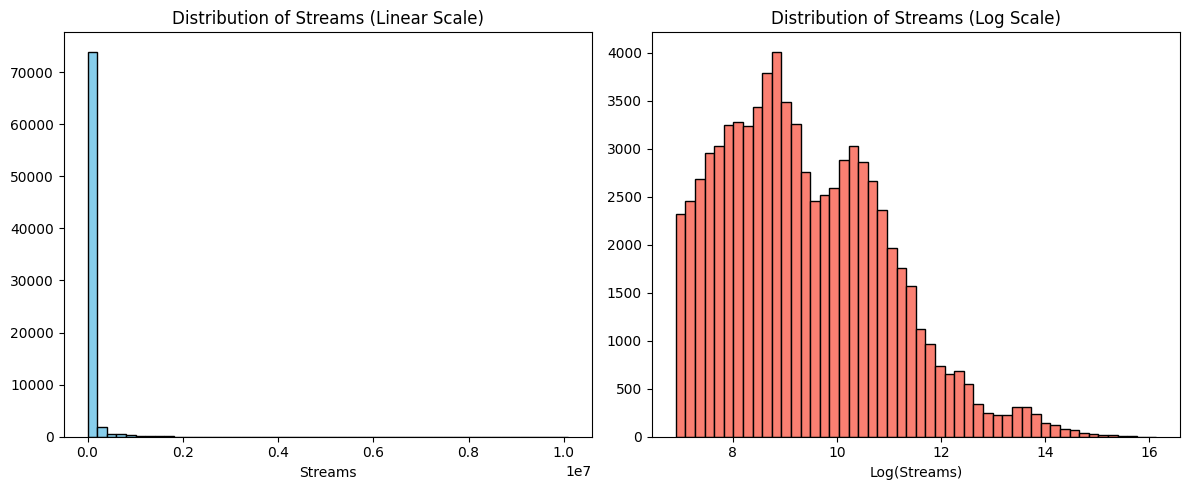

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Sample the data for visualization (as the dataset is too big for full pandas plotting)
sample_df = con.execute("SELECT TRY_CAST(streams AS DOUBLE) as streams FROM spotify_full WHERE streams IS NOT NULL USING SAMPLE 100000").df()

plt.figure(figsize=(12, 5))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution (Following Professor's Checkpoint 1)
plt.subplot(1, 2, 2)
plt.hist(np.log1p(sample_df['streams']), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()

#### Due to Highly Skewed Data we decided to look at the Log Streams

## 8) Audio Feature Distributions

We inspect each numeric audio feature's distribution using a representative **50 000-row random sample**.
By doing so we can examinine feature distributions before building any model.


In [55]:
# Pull a 50 000-row random sample for plotting (avoids loading 26M rows into memory)
SAMPLE_SIZE = 50_000

sample_df = con.execute(f"""
    SELECT
        TRY_CAST(streams AS DOUBLE) AS streams,
        TRY_CAST(af_danceability AS DOUBLE) AS danceability,
        TRY_CAST(af_energy AS DOUBLE) AS energy,
        TRY_CAST(af_valence AS DOUBLE) AS valence,
        TRY_CAST(af_tempo AS DOUBLE) AS tempo,
        TRY_CAST(af_loudness AS DOUBLE) AS loudness,
        TRY_CAST(af_acousticness AS DOUBLE) AS acousticness,
        TRY_CAST(af_speechiness AS DOUBLE) AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness AS DOUBLE) AS liveness,
        TRY_CAST(rank AS DOUBLE) AS rank,
        TRY_CAST(popularity AS DOUBLE) AS popularity,
        chart,
        explicit,
        country_continent,
        year
    FROM spotify_full
    USING SAMPLE {SAMPLE_SIZE} ROWS
""").df()

# Add log_streams
sample_df["log_streams"] = np.log1p(sample_df["streams"].clip(lower=0))

print(f"Sample shape: {sample_df.shape}")
print("\nSample describe (numeric features):")
display(sample_df.describe())


Sample shape: (50000, 17)

Sample describe (numeric features):


,streams,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness,rank,popularity,year,log_streams
count,3.876400e+04,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,50000.000000,49420.000000,50000.000000,38764.000000
mean,5.460607e+04,0.686140,0.643676,0.523793,120.914752,-6.241641,0.255888,0.108682,0.013382,0.169245,80.470860,46.779907,2019.141580,9.393974
std,2.093100e+05,0.137075,0.166400,0.223564,29.225755,2.509917,0.245018,0.099545,0.084631,0.129381,59.077563,30.747543,1.391766,1.551391
min,1.001000e+03,0.078300,0.005430,0.024700,46.660000,-29.377000,0.000002,0.022700,0.000000,0.014600,1.000000,0.000000,2017.000000,6.909753
25%,3.542000e+03,0.602000,0.535000,0.350000,97.028000,-7.460000,0.055900,0.042600,0.000000,0.093500,29.000000,9.000000,2018.000000,8.172729
50%,9.534000e+03,0.704000,0.662000,0.523000,118.034000,-5.833000,0.176000,0.066800,0.000000,0.120000,66.000000,57.000000,2019.000000,9.162725
75%,3.503100e+04,0.786000,0.769000,0.697000,139.985250,-4.534750,0.390000,0.134000,0.000026,0.196000,130.000000,73.000000,2020.000000,10.464017
max,7.913302e+06,0.983000,1.000000,0.982000,230.186000,1.906000,0.996000,0.957000,0.973000,0.990000,200.000000,96.000000,2021.000000,15.884056


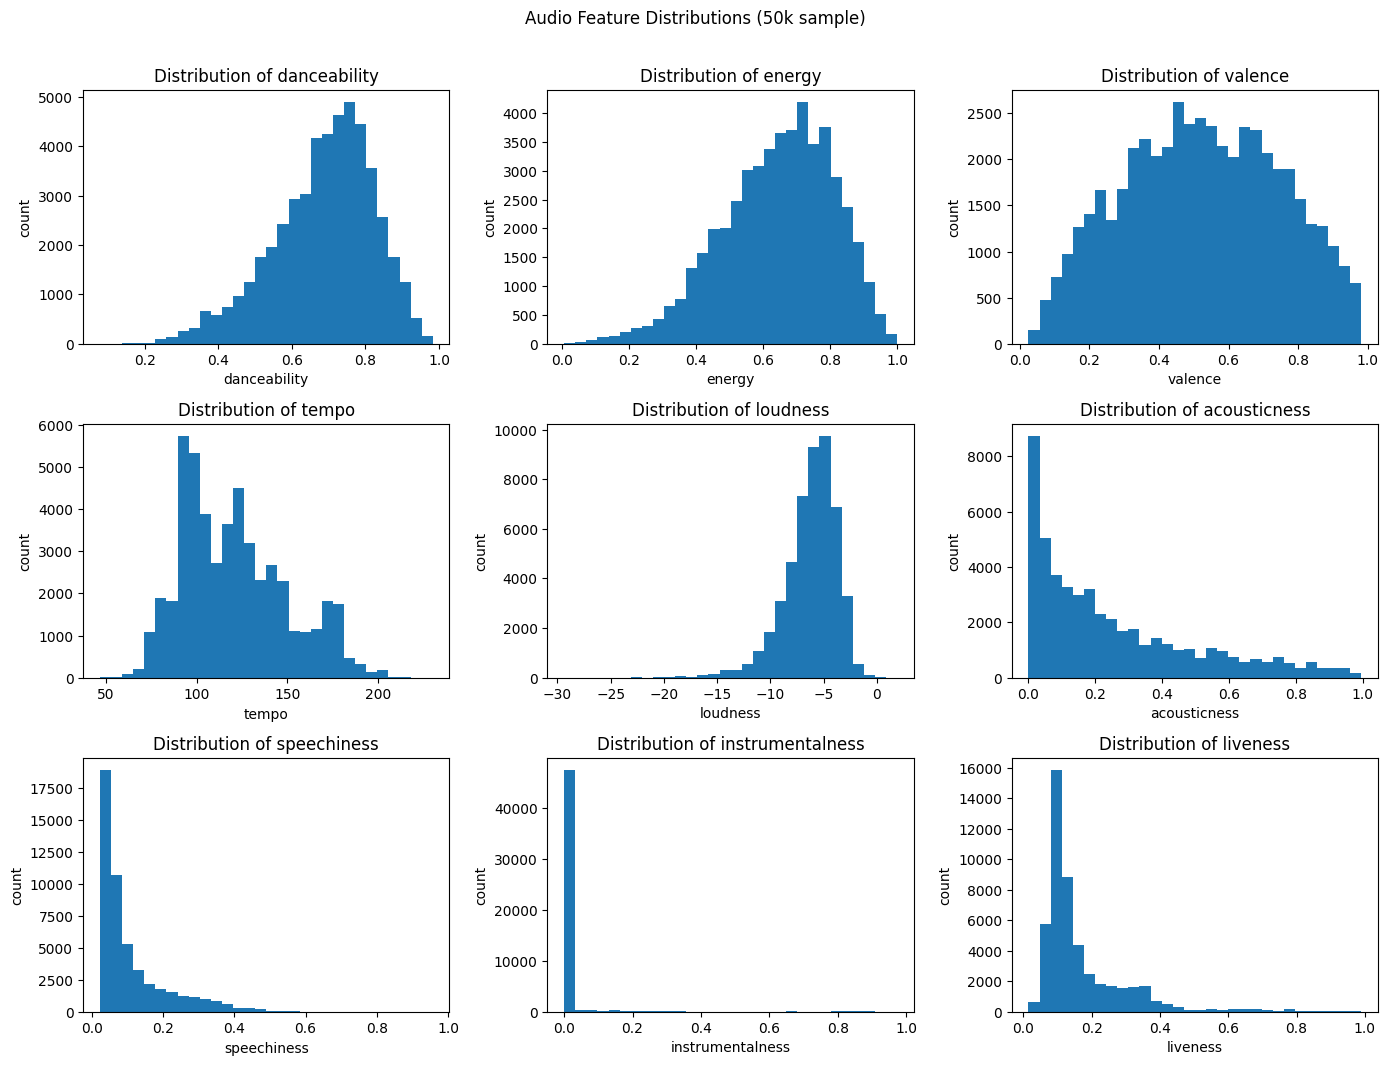

In [56]:
# Histograms of all numeric audio features — mirrors professor's section 3 approach
audio_features = ["danceability", "energy", "valence", "tempo",
                   "loudness", "acousticness", "speechiness",
                   "instrumentalness", "liveness"]

n_cols = 3
n_rows = (len(audio_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    data = sample_df[feat].dropna()
    axes[i].hist(data, bins=30, edgecolor="none")
    axes[i].set_title(f"Distribution of {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("count")

# Hide unused axes
for j in range(len(audio_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Audio Feature Distributions (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


## 9) Streams vs. Numeric Features (Scatter Plots)

Mirrors the professor's `price vs area` scatter — we plot `log(streams)` against each audio feature
to visually assess linear relationships before fitting a model.
We use `log(streams)` on the y-axis because the raw target is heavily right-skewed.


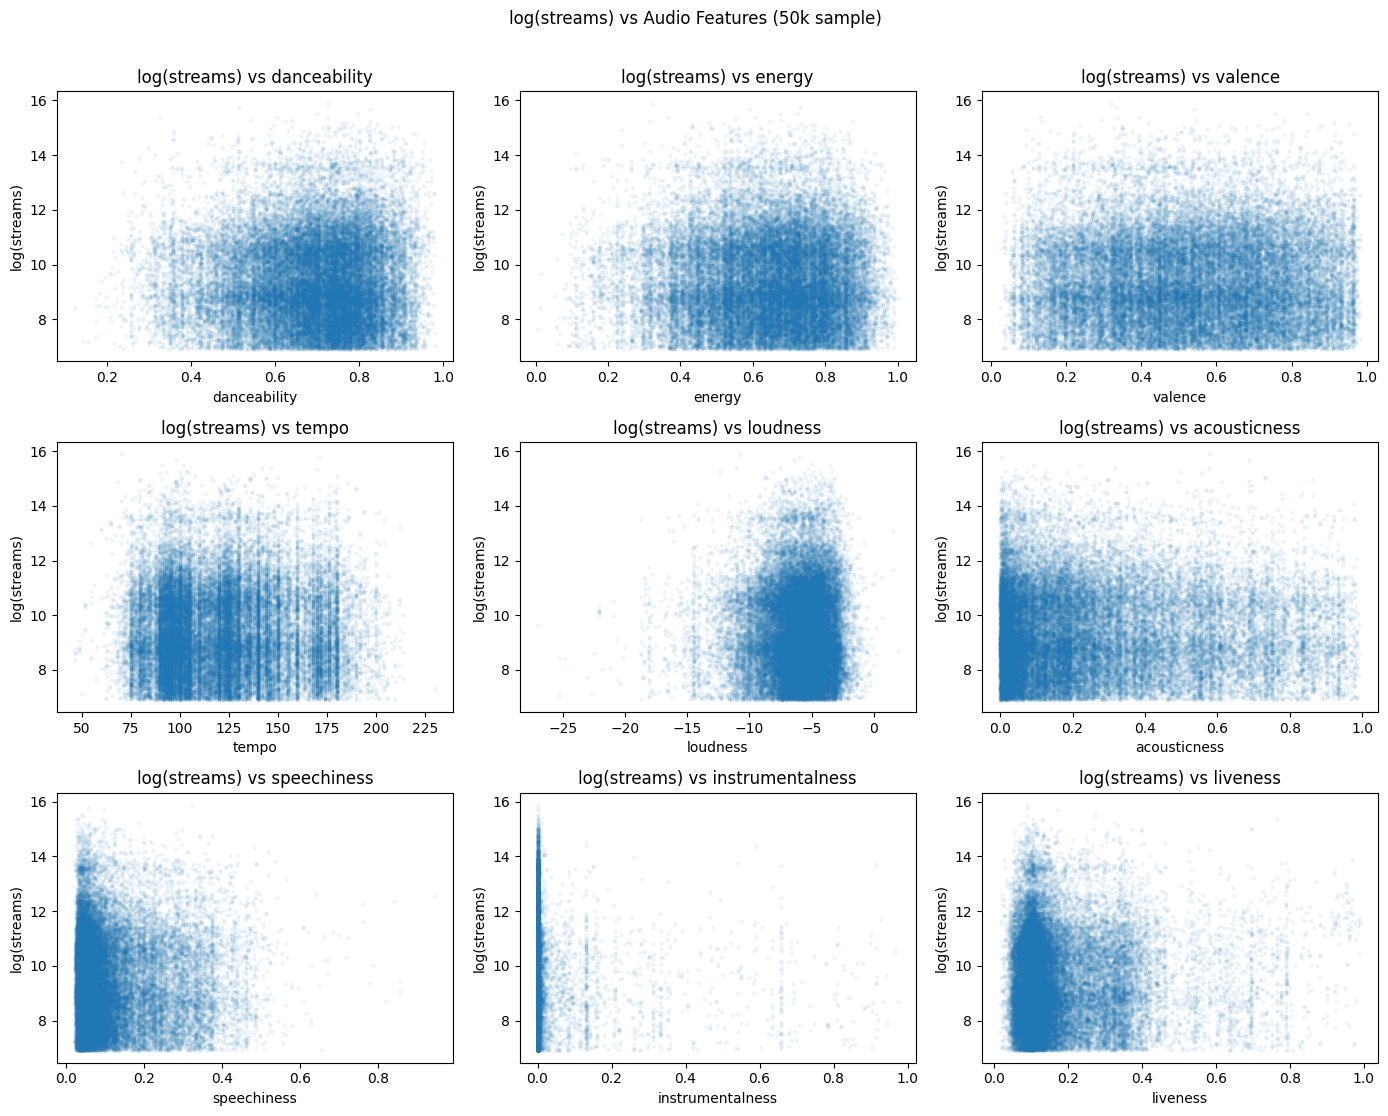

In [57]:
fig, axes = plt.subplots(3, 3, figsize=(14, 11))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    x = sample_df[feat].dropna()
    y = sample_df.loc[x.index, "log_streams"].dropna()
    common = x.index.intersection(y.index)
    axes[i].scatter(x[common], y[common], alpha=0.05, s=5)
    axes[i].set_title(f"log(streams) vs {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("log(streams)")

plt.suptitle("log(streams) vs Audio Features (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


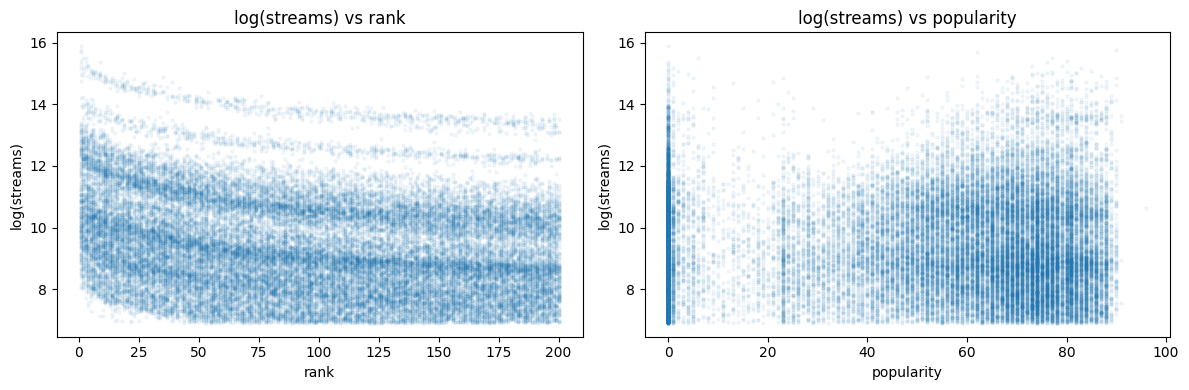

In [58]:
# Also: streams vs rank and popularity
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat in zip(axes, ["rank", "popularity"]):
    mask = sample_df[feat].notna() & sample_df["log_streams"].notna()
    ax.scatter(sample_df.loc[mask, feat], sample_df.loc[mask, "log_streams"],
               alpha=0.05, s=5)
    ax.set_title(f"log(streams) vs {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("log(streams)")

plt.tight_layout()
plt.show()


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_43344/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)
/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_43344/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)
/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_43344/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)


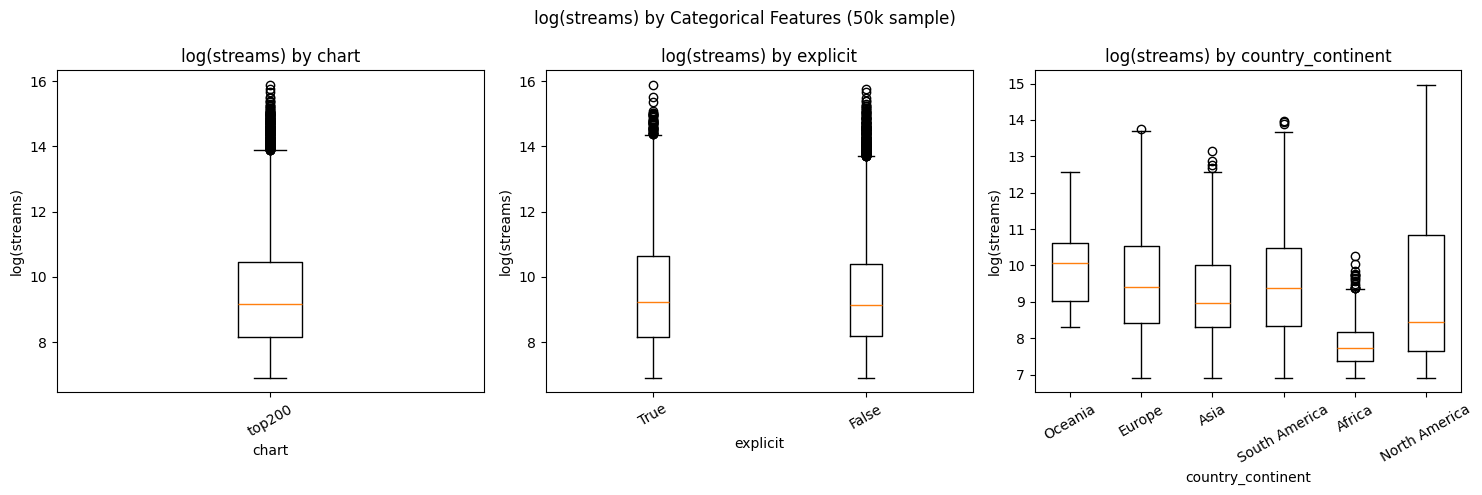

In [59]:
cat_cols = ["chart", "explicit", "country_continent"]

fig, axes = plt.subplots(1, len(cat_cols), figsize=(15, 5))

for ax, col in zip(axes, cat_cols):
    # Group data for boxplot
    groups = [
        sample_df.loc[sample_df[col] == cat, "log_streams"].dropna().values
        for cat in sample_df[col].dropna().unique()
    ]
    labels = list(sample_df[col].dropna().unique())
    # Filter out empty groups
    pairs = [(g, l) for g, l in zip(groups, labels) if len(g) > 0]
    if pairs:
        groups, labels = zip(*pairs)
        ax.boxplot(groups, labels=labels, vert=True)
        ax.set_title(f"log(streams) by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("log(streams)")
        ax.tick_params(axis="x", rotation=30)

plt.suptitle("log(streams) by Categorical Features (50k sample)")
plt.tight_layout()
plt.show()


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_43344/947665740.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(year_groups, labels=year_labels)


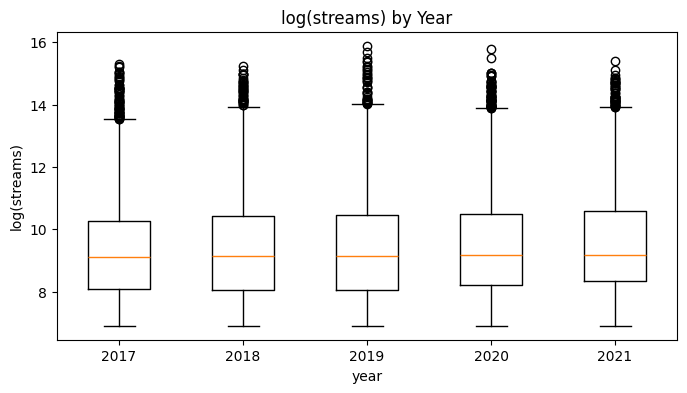

In [60]:
# Year-over-year trend boxplot (mirrors professor's categorical analysis)
year_groups = [
    sample_df.loc[sample_df["year"] == yr, "log_streams"].dropna().values
    for yr in sorted(sample_df["year"].dropna().unique())
]
year_labels = [str(int(yr)) for yr in sorted(sample_df["year"].dropna().unique())]

plt.figure(figsize=(8, 4))
plt.boxplot(year_groups, labels=year_labels)
plt.title("log(streams) by Year")
plt.xlabel("year")
plt.ylabel("log(streams)")
plt.show()


## 10) Categorical Effects on Streams (Box Plots)

Mirrors the professor's boxplots of `price` by categorical features.
Here we show `log(streams)` broken down by `chart` type, `explicit` flag, and `country_continent`.


In [ ]:
## 11) Correlation Matrix

Before modelling we inspect pairwise correlations between the numeric features and the target.
High correlations between features signal potential multicollinearity — something the professor
addresses later with Ridge / Lasso regularization.
